In [ ]:
from pathlib import Path 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from napatrackmater.Trackvector import (TrackVector,
                                        SHAPE_FEATURES, 
                                        DYNAMIC_FEATURES, 
                                        SHAPE_DYNAMIC_FEATURES,
                                        
                                        )

In [38]:
dataset_name = 'Fifth'
home_folder = '/home/debian/jz/'
timelapse_to_track = f'timelapse_{dataset_name.lower()}_dataset'
tracking_directory = f'{home_folder}Mari_Data_Oneat/Mari_{dataset_name}_Dataset_Analysis/nuclei_membrane_tracking/'
channel = 'nuclei_'
data_frames_dir = os.path.join(tracking_directory, f'dataframes/')
save_dir = os.path.join(tracking_directory, f'mitosis_accuracy/')
Path(save_dir).mkdir(exist_ok=True)
master_xml_name = 'master_' + 'marching_cubes_filled_' + channel + timelapse_to_track + ".xml"
xml_path = Path(os.path.join(tracking_directory, master_xml_name))


mitosis_cells_file = f'{home_folder}Mari_Data_Oneat/Mari_{dataset_name}_Dataset_Analysis/mitosis_predicted_tracklet_length_50_t_initial_50_t_final_150/mitosis_inception.csv'
mitosis_cells_dataframe = pd.read_csv(mitosis_cells_file)

non_mitosis_cells_file = f'{home_folder}Mari_Data_Oneat/Mari_{dataset_name}_Dataset_Analysis/mitosis_predicted_tracklet_length_50_t_initial_50_t_final_150/non-mitosis_inception.csv'
non_mitosis_cells_dataframe = pd.read_csv(non_mitosis_cells_file)

gt_dataframe = pd.read_csv(os.path.join(data_frames_dir , f'results_dataframe_normalized_{channel}.csv'))


gt_mitosis_dataframe = gt_dataframe[gt_dataframe['Dividing'] == 1.0]
gt_mitosis_track_ids = list(map(int, gt_mitosis_dataframe['TrackMate Track ID'].unique()))

gt_non_mitosis_dataframe = gt_dataframe[gt_dataframe['Dividing'] == 0.0]
gt_non_mitosis_track_ids = list(map(int, gt_non_mitosis_dataframe['TrackMate Track ID'].unique()))


print(f'Predicted dataframe {len(mitosis_cells_dataframe)},{len(non_mitosis_cells_dataframe)},  gt mitosis dataframe {len(gt_mitosis_track_ids)},  gt non mitosis dataframe {len(gt_non_mitosis_track_ids)}')

Predicted dataframe 360,474,  gt mitosis dataframe 263,  gt non mitosis dataframe 638


In [7]:
track_vectors = TrackVector(master_xml_path=xml_path)
track_vectors.t_minus = 0
track_vectors.t_plus = track_vectors.tend
track_vectors.y_start = 0
track_vectors.y_end = track_vectors.ymax
track_vectors.x_start = 0
track_vectors.x_end = track_vectors.xmax
track_vectors._interactive_function()

Reading Master XML
Iterating over spots in frame
Iterating over tracks 901
getting attributes
returning shape and dynamic vectors as list 1332


In [39]:

mitosis_track_ids = track_vectors._get_trackmate_ids_by_location(mitosis_cells_dataframe)
mitosis_track_ids = list(map(int, mitosis_track_ids))

print(f'Trackmate IDs for mitosis cells {mitosis_track_ids}')

non_mitosis_track_ids = track_vectors._get_trackmate_ids_by_location(non_mitosis_cells_dataframe)
non_mitosis_track_ids = list(map(int, non_mitosis_track_ids))

print(f'Trackmate IDs for non mitosis cells {non_mitosis_track_ids}')


Mitosis Cells - TP: 93, FN: 170


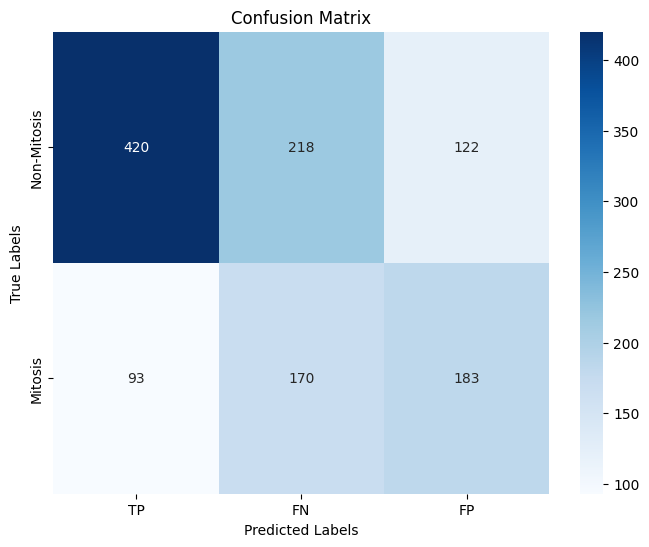

In [36]:
class_map = {
    0: "Non-Mitosis",
    1: "Mitosis",
}
def compute_tp_fn(predicted_ids, gt_ids, gt_other_ids):
    tp = len(set(predicted_ids) & set(gt_ids))
    fn = len(set(gt_ids) - set(predicted_ids))
    fp = len(set(predicted_ids) & set(gt_other_ids))
    return tp, fn, fp

# Compute TP and FN for each category
tp_mitosis, fn_mitosis, fp_mitosis = compute_tp_fn(mitosis_track_ids, gt_mitosis_track_ids, gt_non_mitosis_track_ids)
tp_non_mitosis, fn_non_mitosis, fp_non_mitosis = compute_tp_fn(non_mitosis_track_ids, gt_non_mitosis_track_ids, gt_mitosis_track_ids)

# Print results
print(f'Mitosis Cells - TP: {tp_mitosis}, FN: {fn_mitosis}')

# Create a confusion matrix
confusion_matrix = {
    'Category': ['Non-Mitosis','Mitosis'],
    'TP': [tp_non_mitosis, tp_mitosis],
    'FN': [fn_non_mitosis, fn_mitosis],
    'FP': [fp_non_mitosis, fp_mitosis],
}



conf_matrix_array = np.array([
    [tp_non_mitosis, fn_non_mitosis, fp_non_mitosis],
    [tp_mitosis, fn_mitosis, fp_mitosis]
])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
class_names = list(class_map.values())
sns.heatmap(conf_matrix_array, annot=True, fmt='d', cmap='Blues', xticklabels=['TP', 'FN', 'FP'], yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()    


Mitosis Cells - TP: 35.36%, FN: 64.64%


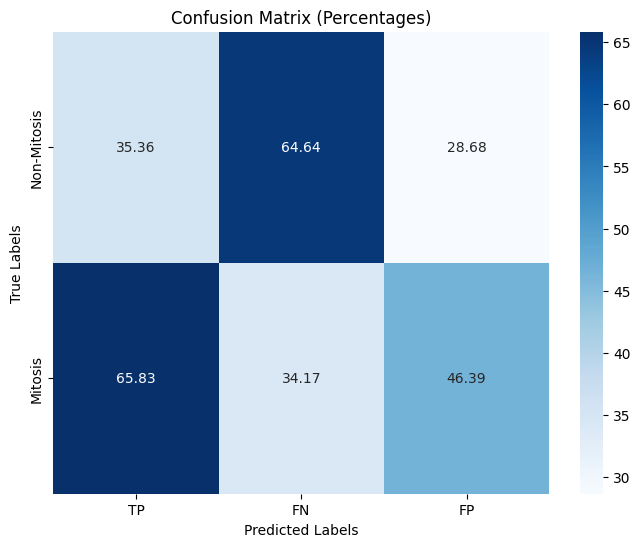

In [37]:
# Total ground truth counts for each category
total_mitosis = len(gt_mitosis_track_ids)
percent_tp_mitosis = (tp_mitosis / total_mitosis) * 100 if total_mitosis > 0 else 0
percent_fn_mitosis = (fn_mitosis / total_mitosis) * 100 if total_mitosis > 0 else 0

total_non_mitosis = len(gt_non_mitosis_track_ids)
percent_tp_non_mitosis = (tp_non_mitosis / total_non_mitosis) * 100 if total_non_mitosis > 0 else 0
percent_fn_non_mitosis = (fn_non_mitosis / total_non_mitosis) * 100 if total_non_mitosis > 0 else 0

percent_fp_mitosis = (fp_mitosis / total_non_mitosis) * 100 if total_mitosis > 0 else 0
percent_fp_non_mitosis = (fp_non_mitosis / total_mitosis) * 100 if total_non_mitosis > 0 else 0

print(f'Mitosis Cells - TP: {percent_tp_mitosis:.2f}%, FN: {percent_fn_mitosis:.2f}%')

# Create a confusion matrix array
conf_matrix_array = np.array([
    [percent_tp_mitosis, percent_fn_mitosis, percent_fp_mitosis],
    [percent_tp_non_mitosis, percent_fn_non_mitosis, percent_fp_non_mitosis]
])

save_path = Path(mitosis_cells_file).parent.stem
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
class_names = list(class_map.values())
sns.heatmap(conf_matrix_array, annot=True, fmt='.2f', cmap='Blues', xticklabels=['TP', 'FN', 'FP'], yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Percentages)')
plt.savefig(os.path.join(save_dir,save_path + '.png'))
plt.show()